In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader_Lazy, read_and_prepare_data
from torch_geometric_temporal.signal import temporal_signal_split
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
from tqdm import tqdm

In [3]:
model_name = 'A3TGCN_20231216053226_T1330_epochs-200_in-12_out-4_train-ratio-0.7_lr-0.01_hidden-128.pt'
trafo_id = "T1330"
num_timesteps_in = 12
num_timesteps_out = 4
train_ratio = 0.7
test_ratio_vs_eval_ratio = 0.5
hidden = 128

In [4]:
# print("Loading data...")
# loader = SimpleGraphVoltDatasetLoader(trafo_id)
# loader_data = loader.get_dataset(num_timesteps_in=num_timesteps_in, num_timesteps_out=num_timesteps_out)

# train_dataset, test_eval_dataset = temporal_signal_split(loader_data, train_ratio=train_ratio)
# test_dataset, eval_dataset = temporal_signal_split(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)

# print("Loading data...")
# loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
# print(" done")
# loader_data_index = loader.snapshot_index

# train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy(loader_data_index, train_ratio=train_ratio)
# test_dataset, eval_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)

print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
print(" done")
loader_data_index = loader.snapshot_index

# train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy(loader_data_index, train_ratio=train_ratio)
train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy_cut(loader_data_index)
test_dataset, eval_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...


Voltage index: 5
 done


In [5]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, hidden=32):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        out_channels = hidden
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=out_channels, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(out_channels, periods)

    def forward(self, x, edge_index,edge_weight):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index,edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [6]:
#read saved model
device = torch.device('cpu')
model = TemporalGNN(loader.num_features, num_timesteps_out, hidden).to(device)
model.load_state_dict(torch.load(f"../models/{model_name}", map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
import matplotlib.pyplot as plt

In [8]:
voltage_std = loader.mean_and_std["measurements"][1]["voltage"]

In [9]:
node = 50

In [10]:
# preds = []
# ys = []
# model.eval()
# with torch.no_grad():
#     for snapshot in tqdm(eval_dataset):
#         x = snapshot.x
#         edge_index = snapshot.edge_index
#         y = snapshot.y
#         snapshot = snapshot.to(device)
#         pred = model(snapshot.x, snapshot.edge_index)
#         pred = pred.detach().numpy()
#         y = snapshot.y.detach().numpy()
#         ys.append(y[node, 0]*voltage_std)
#         preds.append(pred[node, 0]*voltage_std)
preds = []
ys = []
model.eval()
with torch.no_grad():
    for snapshot_i in tqdm(eval_dataset, desc="Evaluating"):
        snapshot = loader.get_snapshot(snapshot_i)
        snapshot = snapshot.to(device)
        pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_weight)
        pred = pred.detach().numpy()
        y = snapshot.y.detach().numpy()
        ys.append(y*voltage_std)
        preds.append(pred*voltage_std)


Evaluating:   0%|          | 0/1440 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1440/1440 [00:16<00:00, 89.79it/s]


In [11]:
ys = np.stack(ys, axis=-1)
preds = np.stack(preds, axis=-1)

In [12]:
ys.shape

(113, 4, 1440)

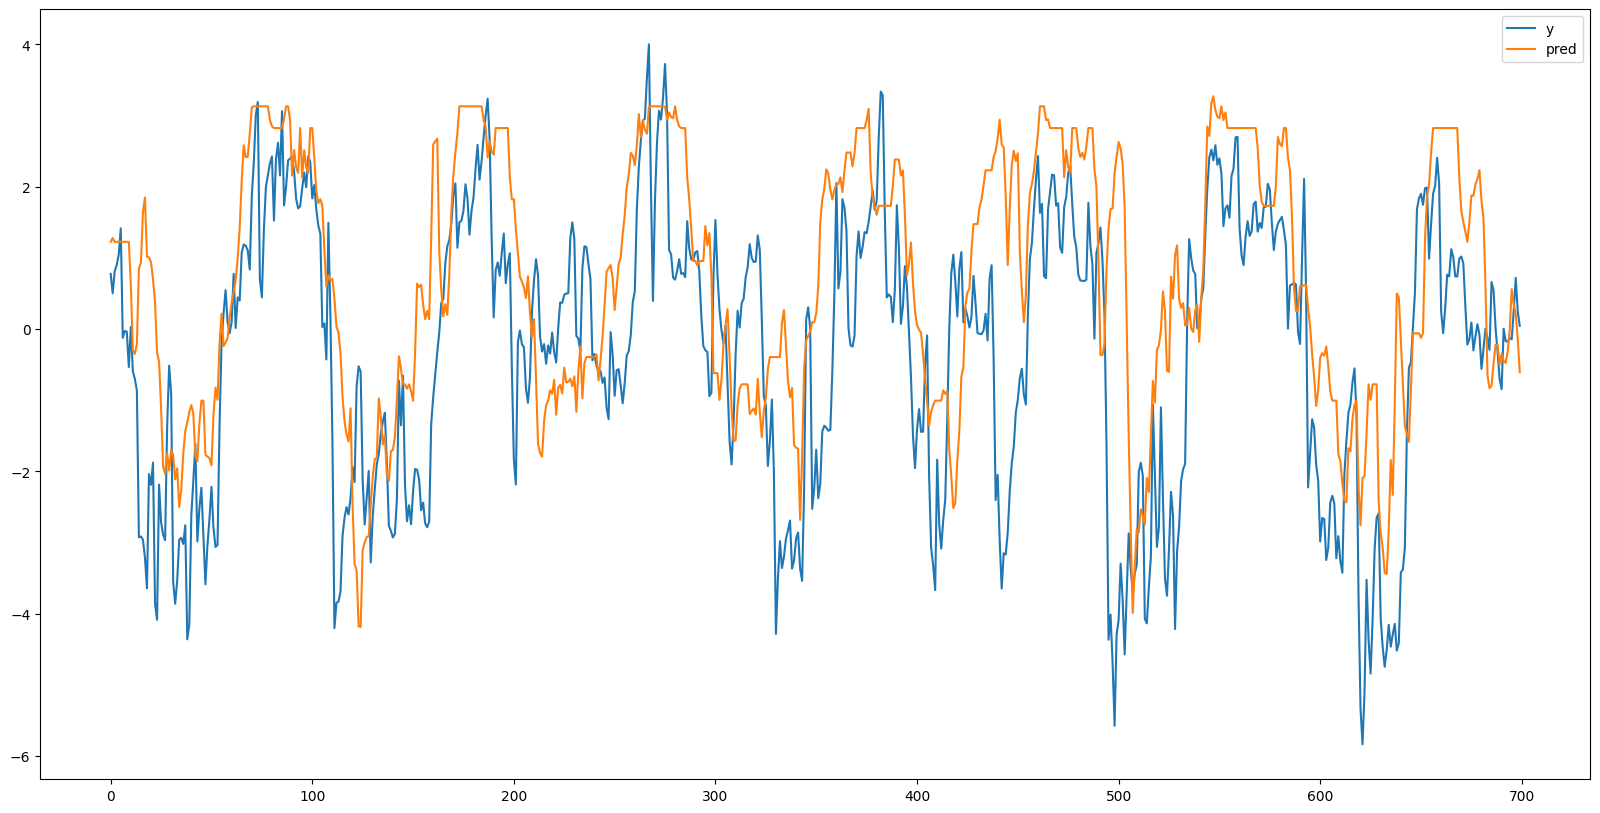

In [13]:
node = 50
time_i = 0

change = 0

start = 100+change
end = 800+change

#make bigger plot
plt.figure(figsize=(20, 10))
plt.plot(ys[node, time_i, start:end], label="y")
plt.plot(preds[node, time_i, start:end], label="pred")
plt.legend()

In [14]:
dataset = eval_dataset
ind = 1000
x = dataset[ind].x
edge_index = dataset[ind].edge_index
y = dataset[ind].y
node = 1
voltage = 5
x[node, voltage, :]


AttributeError: 'int' object has no attribute 'x'

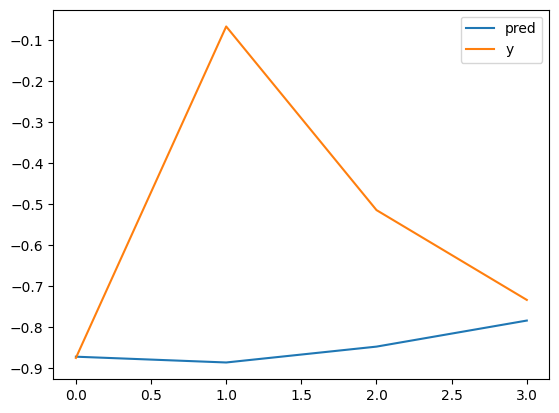

In [ ]:
model.eval()
with torch.no_grad():
    pred = model(x, edge_index)
pred_node = pred[node, :]
plt.plot(pred_node*voltage_std, label="pred")
plt.plot(y[node, :]*voltage_std, label="y")
plt.legend()